In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import sparse, stats
from sklearn.model_selection import KFold

from pynba import possessions_from_file, use_blackontrans_style

%load_ext pyinstrument

use_blackontrans_style()
league = "nba"
years = [2015, 2016, 2017, 2018, 2019]
# years = [2019]
season_type = "Regular Season"

possessions = pd.concat([possessions_from_file(league, year, season_type) for year in years])
nba_player_ids = pd.read_csv("/home/jupyter/nba/data/NBA_Player_IDs.csv", encoding_errors="ignore")
player_id_mapping = {
    int(player_id): player_name
    for player_name, player_id
    in zip(nba_player_ids["NBAName"], nba_player_ids["NBAID"])
    if not pd.isna(player_id)
}

In [2]:
POSS_COLS = [
    "off_player0", "off_player1", "off_player2", "off_player3", "off_player4", 
    "def_player0", "def_player1", "def_player2", "def_player3", "def_player4",
    "points_scored", "possession_num"
]


def calc_rapm(possessions, prior):
    var = calc_variance(possessions)
    stints = calc_stints(possessions)
    player_ids = np.unique(stints.loc[:, [f"off_player{ind}" for ind in range(5)] + [f"def_player{ind}" for ind in range(5)]])
    X = calc_X(stints, player_ids)
    XT_W = calc_XT_W(X, stints)
    G = calc_G(X, var, prior)
    y = calc_y(stints)
    A, b = calc_A_b(X, XT_W, G, y)
    x = solve_for_x(A, b)
    r = y - X.dot(x)
    rss = (r * stints["possession_num"]).T.dot(r)
    sigma2 = rss / (X.shape[0] - X.shape[1] - 1)
    cov_x = sigma2 * sparse.linalg.inv(A.tocsc())
    off_rapm, def_rapm = x[:player_ids.shape[0]], -x[player_ids.shape[0]:]
    rapm = off_rapm + def_rapm
    x_var = cov_x.diagonal()
    off_def_cov = cov_x.diagonal(player_ids.shape[0])
    off_rapm_var, def_rapm_var = x_var[:player_ids.shape[0]], x_var[player_ids.shape[0]:]
    rapm_var = off_rapm_var + def_rapm_var + 2 * off_def_cov
    rapm_std, off_rapm_std, def_rapm_std = np.sqrt(rapm_var), np.sqrt(off_rapm_var), np.sqrt(def_rapm_var)
    poss = np.asarray(XT_W.sum(1)).reshape(-1)
    off_poss, def_poss = poss[:player_ids.shape[0]], poss[player_ids.shape[0]:]
    raw_pm = b / poss.reshape(-1)
    off_raw_pm, def_raw_pm = raw_pm[:player_ids.shape[0]], -raw_pm[player_ids.shape[0]:]
    raw_pm = off_raw_pm + def_raw_pm
    names = [player_id_mapping.get(player_id, "n/a") for player_id in player_ids]
    return pd.DataFrame({
        "name": names,
        "rapm": rapm,
        "off_rapm": off_rapm,
        "def_rapm": def_rapm,
        "rapm_std": rapm_std,
        "off_rapm_std": off_rapm_std,
        "def_rapm_std": def_rapm_std,
        "off_poss": off_poss,
        "def_poss": def_poss,
        "raw_pm": raw_pm,
        "off_raw_pm": off_raw_pm,
        "def_raw_pm": def_raw_pm,
    }, index=player_ids)


def calc_stints(possessions):
    poss = possessions.loc[:, POSS_COLS]
    off_player_ids = poss[[f"off_player{ind}" for ind in range(5)]].to_numpy()
    off_player_ids.sort(1)
    poss["off_player_ids"] = [row.tobytes() for row in off_player_ids]
    def_player_ids = poss[[f"def_player{ind}" for ind in range(5)]].to_numpy()
    def_player_ids.sort(1)
    poss["def_player_ids"] = [row.tobytes() for row in def_player_ids]
    return poss.groupby(by=["off_player_ids", "def_player_ids"]).agg(
        {
            "off_player0": "first",
            "off_player1": "first",
            "off_player2": "first",
            "off_player3": "first",
            "off_player4": "first",
            "def_player0": "first",
            "def_player1": "first",
            "def_player2": "first",
            "def_player3": "first",
            "def_player4": "first",
            "points_scored": "sum",
            "possession_num": "count",
        }
    ).reset_index()


def calc_X(stints, player_ids):
    off_player_ids = stints.loc[:, [f"off_player{ind}" for ind in range(5)]]
    def_player_ids = stints.loc[:, [f"def_player{ind}" for ind in range(5)]]
    n_players = player_ids.shape[0]
    n_stints = stints.shape[0]

    X = sparse.lil_matrix((2 * n_players, n_stints))
    for ind, player_id in enumerate(player_ids):
        X[ind, :] = (player_id == off_player_ids).any(1)
        X[n_players + ind, :] = (player_id == def_player_ids).any(1)

    return X.T.tocsr().astype("float64")


def calc_y(stints):
    mu = stints["points_scored"].sum() / stints["possession_num"].sum()
    y = (stints["points_scored"] / stints["possession_num"] - mu) * 100
    return y.to_numpy().astype("float64")


def calc_XT_W(X, stints):
    w = stints["possession_num"].to_numpy().astype("float64").reshape(-1, 1)
    return X.multiply(w).T.tocsr()


def calc_G(X, var, prior):
    return sparse.diags([var / prior ** 2] * X.shape[1])


def calc_A_b(X, XT_W, G, y):
    A = XT_W.dot(X) + G
    b = XT_W.dot(y)
    return A, b


def calc_variance(possessions):
    counts = possessions["points_scored"].value_counts()
    p = counts / possessions.shape[0]
    eff = counts.index * 100
    return ((eff ** 2) * p).sum() - (eff * p).sum() ** 2


def solve_for_x(A, b):
    return sparse.linalg.spsolve(A, b)


## Calculating RAPM

In [3]:
prior = 2
%pyinstrument  rapm = calc_rapm(possessions, prior)
rapm.describe()

_     ._   __/__   _ _  _  _ _/_   Recorded: 06:14:33  Samples:  7904
 /_//_/// /_\ / //_// / //_'/ //     Duration: 31.848    CPU time: 43.536
/   _/                      v4.1.1

Program: /home/jupyter/.venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/jupyter/.local/share/jupyter/runtime/kernel-519bc40e-0865-4216-bb9f-3c3582465554.json

31.848 <module>  ../../../tmp/ipykernel_283/1326332489.py:2
`- 31.840 calc_rapm  ../../../tmp/ipykernel_283/1978333943.py:8
   |- 21.978 calc_X  ../../../tmp/ipykernel_283/1978333943.py:77
   |  |- 18.827 __setitem__  scipy/sparse/lil.py:323
   |  |     [75 frames hidden]  scipy, <built-in>, <__array_function_...
   |  |        17.716 lil_fancy_set  <built-in>:0
   |  |- 1.480 __array_ufunc__  pandas/core/generic.py:2029
   |  |     [170 frames hidden]  pandas, <built-in>, typing, numpy
   |  |- 1.101 __getattr__  scipy/sparse/base.py:673
   |  |     [23 frames hidden]  scipy, <built-in>
   |  `- 0.448 any  pandas/core/generic.py:10520
   |        [95 frames hidden]  pandas, <built-in>, numpy
   |- 6.116 inv  scipy/sparse/linalg/matfuncs.py:33
   |     [36 frames hidden]  scipy, <built-in>, numpy, <__array_fu...
   |- 2.521 calc_stints  ../../../tmp/ipykernel_283/1978333943.py:51
   |  |- 1.342 aggregate  pandas/core/groupby/generic.py:964
   |  |     [133 frames hidden]  pandas, <built-in>, <__array_function...
   |  |- 0.380 <listcomp>  ../../../tmp/ipykernel_283/1978333943.py:58
   |  `- 0.364 <listcomp>  ../../../tmp/ipykernel_283/1978333943.py:55
   `- 0.694 solve_for_x  ../../../tmp/ipykernel_283/1978333943.py:119
      `- 0.694 spsolve  scipy/sparse/linalg/dsolve/linsolve.py:91
            [7 frames hidden]  scipy, <built-in>

,rapm,off_rapm,def_rapm,rapm_std,off_rapm_std,def_rapm_std,off_poss,def_poss,raw_pm,off_raw_pm,def_raw_pm
count,9.000000e+02,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,-3.221127e-15,-0.201799,0.201799,2.054704,1.453475,1.453664,6702.561111,6702.561111,-3.243113,-3.331785,0.088672
std,1.922404e+00,1.435618,1.199334,0.536550,0.378921,0.378941,7294.577260,7297.828294,11.811845,8.879199,9.393025
min,-5.660059e+00,-4.126315,-3.730105,1.152094,0.812989,0.812623,1.000000,1.000000,-84.761905,-106.765987,-84.143103
25%,-1.078278e+00,-1.030703,-0.454981,1.520673,1.077098,1.077428,587.000000,581.000000,-6.774955,-5.932610,-2.551173
50%,-1.352805e-01,-0.228275,0.126354,2.039912,1.444081,1.443632,3757.000000,3748.000000,-2.150482,-2.057163,-0.024653
75%,8.721585e-01,0.394274,0.888467,2.617770,1.851402,1.850634,11133.000000,11139.000000,1.460500,0.845844,2.542979
max,1.091907e+01,9.062128,4.534685,2.824064,1.996915,1.996915,29564.000000,29566.000000,95.000000,68.234013,106.765987


## Scoring priors using cross-validation

We calculate X once and then split it since ~80% of the time to calculate RAPM is taken up by that task.

In [4]:
def score_rapm_cv(possessions, priors):
    var = calc_variance(possessions)
    stints = calc_stints(possessions)
    player_ids = np.unique(stints.loc[:, [f"off_player{ind}" for ind in range(5)] + [f"def_player{ind}" for ind in range(5)]])
    X = calc_X(stints, player_ids)
    y = calc_y(stints)
    weighted_rmse = np.zeros(priors.shape)
    for train_index, test_index in KFold(n_splits=10).split(X):
        X_train = X[train_index]
        stints_train = stints.iloc[train_index, :]
        XT_W_train = calc_XT_W(X_train, stints_train)
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        stints_test = stints.iloc[test_index, :]
        for ind, prior in enumerate(priors):
            G_train = calc_G(X_train, var, prior)
            A_train, b_train = calc_A_b(X_train, XT_W_train, G_train, y_train)
            x = solve_for_x(A_train, b_train)
            weighted_rmse[ind] += ((y_test - X_test.dot(x)) ** 2 * stints_test["possession_num"]).sum()
    return np.sqrt(weighted_rmse / stints["possession_num"].sum())

In [5]:
priors = np.linspace(1, 3, 9)
%pyinstrument scores = score_rapm_cv(possessions, priors=priors)
{prior: score for prior, score in zip(priors, scores)}

_     ._   __/__   _ _  _  _ _/_   Recorded: 06:15:07  Samples:  6992
 /_//_/// /_\ / //_// / //_'/ //     Duration: 135.724   CPU time: 797.622
/   _/                      v4.1.1

Program: /home/jupyter/.venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/jupyter/.local/share/jupyter/runtime/kernel-519bc40e-0865-4216-bb9f-3c3582465554.json

135.723 <module>  ../../../tmp/ipykernel_283/2074541620.py:2
`- 135.700 score_rapm_cv  ../../../tmp/ipykernel_283/1154323842.py:1
   |- 84.080 solve_for_x  ../../../tmp/ipykernel_283/1978333943.py:119
   |  `- 84.080 spsolve  scipy/sparse/linalg/dsolve/linsolve.py:91
   |        [24 frames hidden]  scipy, <built-in>
   |           81.300 gssv  <built-in>:0
   |- 25.176 calc_A_b  ../../../tmp/ipykernel_283/1978333943.py:106
   |  `- 24.812 dot  scipy/sparse/base.py:346
   |        [32 frames hidden]  scipy, <built-in>, numpy, <__array_fu...
   |- 22.355 calc_X  ../../../tmp/ipykernel_283/1978333943.py:77
   |  `- 19.016 __setitem__  scipy/sparse/lil.py:323
   |        [92 frames hidden]  scipy, <built-in>, <__array_function_...
   `- 2.593 calc_stints  ../../../tmp/ipykernel_283/1978333943.py:51
      `- 1.535 aggregate  pandas/core/groupby/generic.py:964
            [130 frames hidden]  pandas, <built-in>, <__array_function...

{1.0: 58.87612666611334,
 1.25: 58.857456068831006,
 1.5: 58.84727288449947,
 1.75: 58.84261233525252,
 2.0: 58.84151074944906,
 2.25: 58.84267627103919,
 2.5: 58.845262714688154,
 2.75: 58.848717060488596,
 3.0: 58.852678197824474}

## Finding the optimal prior by fitting scores to a quadratic

Can we save time by fitting the scores to a quadratic?

In [6]:
def find_best_priors(priors, scores):
    X = np.array([priors ** 2, priors, np.ones(priors.shape[0])]).T
    y = scores.reshape(-1)
    res = np.linalg.lstsq(X, y, rcond=None)
    a, b, c = res[0]
    x_h = np.linspace(priors.min(), priors.max())
    y_h = a * x_h ** 2 + b * x_h + c
    return -b / (2 * a), x_h, y_h

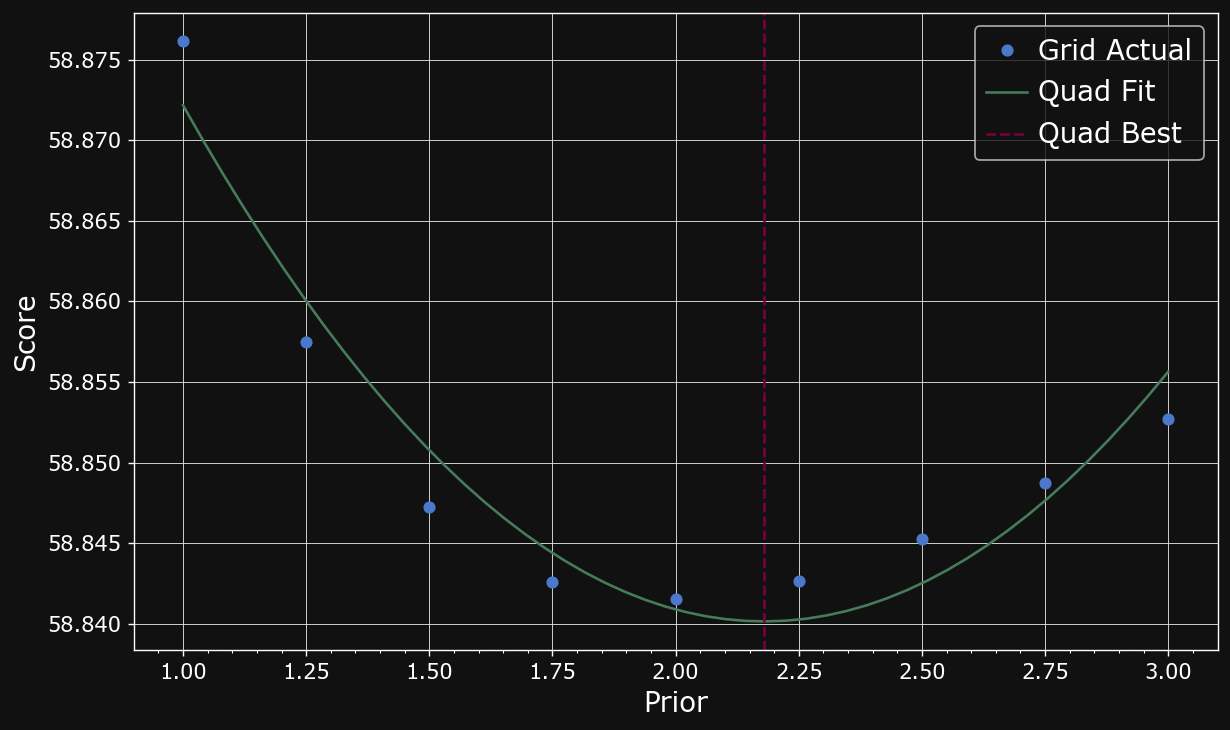

In [7]:
prior, x_h, y_h = find_best_priors(priors, scores)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(priors, scores, "o", label="Grid Actual")
ax.plot(x_h, y_h, label="Quad Fit")
ax.axvline(prior, ls="--", c="C2", label="Quad Best")
ax.set_xlabel("Prior")
ax.set_ylabel("Score")
ax.legend();

## Optimizing the prior using pattern search

Cutting the search space in half takes 1.5 evaluations (we're assuming the search space is convex).

In [8]:
def optimize(func, rounds, *args):
    bounds = np.array([[arg[0], arg[1]] for arg in args]).astype(float)
    x1 = bounds.mean(1)
    y1 = func(*x1)
    steps = np.diff(bounds, 1).reshape(-1) / 4
    history = [(tuple(x1), y1)]
    for _ in range(rounds):
        for ind, step in enumerate(steps):
            x0 = x1.copy()
            x0[ind] -= step
            y0 = func(*x0)
            history.append((tuple(x0), y0))
            if y0 < y1:
                bounds[ind, 1] = x1[ind]
                x1, y1 = x0, y0
                continue
            x2 = x1.copy()
            x2[ind] += step
            y2 = func(*x2)
            history.append((tuple(x2), y2))
            if y2 < y1:
                bounds[ind, 0] = x1[ind]
                x1, y1 = x2, y2
            else:
                bounds[ind, 0] = x0[ind]
                bounds[ind, 1] = x2[ind]
        steps /= 2
    return tuple(x1), y1, bounds, history


def optimize_rapm_cv(possessions, rounds, prior_range):
    var = calc_variance(possessions)
    stints = calc_stints(possessions)
    player_ids = np.unique(stints.loc[:, [f"off_player{ind}" for ind in range(5)] + [f"def_player{ind}" for ind in range(5)]])
    X = calc_X(stints, player_ids)
    y = calc_y(stints)
    def objective(prior):
        return _score_rapm_cv(X, y, stints, var, prior)
    return optimize(objective, rounds, prior_range)


def _score_rapm_cv(X, y, stints, var, prior):
    weighted_rmse = 0
    for train_index, test_index in KFold(n_splits=10).split(X):
        X_train = X[train_index]
        stints_train = stints.iloc[train_index, :]
        XT_W_train = calc_XT_W(X_train, stints_train)
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        stints_test = stints.iloc[test_index, :]
        G_train = calc_G(X_train, var, prior)
        A_train, b_train = calc_A_b(X_train, XT_W_train, G_train, y_train)
        x = solve_for_x(A_train, b_train)
        weighted_rmse += ((y_test - X_test.dot(x)) ** 2 * stints_test["possession_num"]).sum()
    return np.sqrt(weighted_rmse / stints["possession_num"].sum())

In [9]:
prior_range = (1, 3)
rounds = 6
%pyinstrument best_prior, lowest_score, best_range, history = optimize_rapm_cv(possessions, rounds, prior_range)

_     ._   __/__   _ _  _  _ _/_   Recorded: 06:17:24  Samples:  11108
 /_//_/// /_\ / //_// / //_'/ //     Duration: 202.791   CPU time: 1195.854
/   _/                      v4.1.1

Program: /home/jupyter/.venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/jupyter/.local/share/jupyter/runtime/kernel-519bc40e-0865-4216-bb9f-3c3582465554.json

202.791 <module>  ../../../tmp/ipykernel_283/4114580168.py:2
`- 202.776 optimize_rapm_cv  ../../../tmp/ipykernel_283/3484834971.py:31
   |- 177.899 optimize  ../../../tmp/ipykernel_283/3484834971.py:1
   |  `- 177.899 objective  ../../../tmp/ipykernel_283/3484834971.py:37
   |     `- 177.812 _score_rapm_cv  ../../../tmp/ipykernel_283/3484834971.py:42
   |        |- 129.535 solve_for_x  ../../../tmp/ipykernel_283/1978333943.py:119
   |        |  `- 129.535 spsolve  scipy/sparse/linalg/dsolve/linsolve.py:91
   |        |        [9 frames hidden]  scipy, <built-in>
   |        |           125.354 gssv  <built-in>:0
   |        |- 31.272 calc_A_b  ../../../tmp/ipykernel_283/1978333943.py:106
   |        |  `- 30.723 dot  scipy/sparse/base.py:346
   |        |        [10 frames hidden]  scipy, <built-in>
   |        |- 10.092 calc_XT_W  ../../../tmp/ipykernel_283/1978333943.py:97
   |        |  |- 5.235 multiply  scipy/sparse/compressed.py:365
   |        |  |     [35 frames hidden]  scipy, numpy, <built-in>
   |        |  `- 2.944 tocsr  scipy/sparse/coo.py:372
   |        |        [7 frames hidden]  scipy, <built-in>
   |        `- 3.969 __getitem__  pandas/core/indexing.py:918
   |              [57 frames hidden]  pandas, <built-in>, numpy
   |- 22.144 calc_X  ../../../tmp/ipykernel_283/1978333943.py:77
   |  `- 18.708 __setitem__  scipy/sparse/lil.py:323
   |        [88 frames hidden]  scipy, <built-in>, <__array_function_...
   `- 2.495 calc_stints  ../../../tmp/ipykernel_283/1978333943.py:51

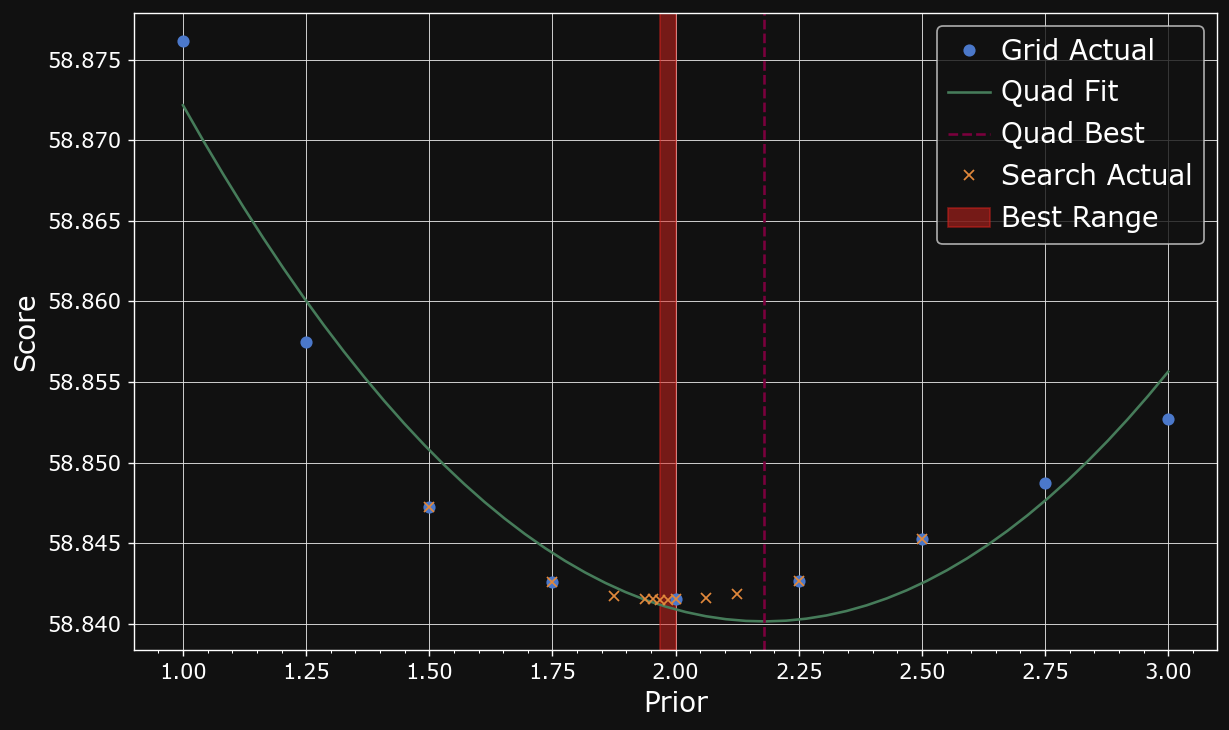

In [10]:
new_priors, new_scores = list(zip(*history))
new_priors = [prior[0] for prior in new_priors]

ax.plot(new_priors, new_scores, "C3x", label="Search Actual")
ax.axvspan(best_range[0, 0], best_range[0, 1], color="C4", alpha=0.5, label="Best Range")
ax.legend()
fig

In [11]:
rapm = calc_rapm(possessions, best_prior[0])
rapm.sort_values(by="rapm", ascending=False).head(30)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(rapm["off_rapm"], rapm["def_rapm"], ".")
ax.set_xlabel("Offense")
ax.set_ylabel("Defense")
ax.set_title(f"{league.upper()} {min(years)}-{max(years)} {season_type} RAPM")
ax.axis("equal");

,rapm,off_rapm,def_rapm,rapm_std,off_rapm_std,def_rapm_std,off_poss,def_poss,raw_pm,off_raw_pm,def_raw_pm
count,9.000000e+02,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,-3.142178e-15,-0.200457,0.200457,2.044113,1.445974,1.446161,6702.561111,6702.561111,-3.243113,-3.331785,0.088672
std,1.911260e+00,1.427763,1.191585,0.529903,0.374231,0.374250,7294.577260,7297.828294,11.811845,8.879199,9.393025
min,-5.639698e+00,-4.120684,-3.705295,1.149983,0.811478,0.811112,1.000000,1.000000,-84.761905,-106.765987,-84.143103
25%,-1.074533e+00,-1.024668,-0.447963,1.516544,1.074152,1.074478,587.000000,581.000000,-6.774955,-5.932610,-2.551173
50%,-1.330829e-01,-0.226526,0.124846,2.031225,1.437928,1.437473,3757.000000,3748.000000,-2.150482,-2.057163,-0.024653
75%,8.656006e-01,0.390476,0.879253,2.600171,1.838951,1.838198,11133.000000,11139.000000,1.460500,0.845844,2.542979
max,1.088163e+01,9.023380,4.513339,2.802050,1.981349,1.981349,29564.000000,29566.000000,95.000000,68.234013,106.765987
